In [1]:
from math import log
import operator

#计算信息熵
def cal_Ent(data_set):
    num=len(data_set) #记录条数
    label_counts={}  #字典放类别(yes/no)
    for i in range(num):  #遍历data_set中的每一条记录
        current_label=data_set[i][-1] #只取最后一列数据(Play?)
        if current_label not in label_counts.keys(): #如果这个属性没在label_counts中出现
            label_counts[current_label]=0  #就把这个键的值赋为0
        label_counts[current_label]+=1  #让当前键的值+1
    Ent=0.0
    for key in label_counts:
        prob=float(label_counts[key])/num
        Ent=Ent-prob*log(prob,2)
    return Ent


In [2]:
#切割该数据集,返回不包含axis列的子数据集
def split_data_set(data_set, axis, value):
    ret_data_set = []
    for feat_vec in data_set:
        if feat_vec[axis] == value:
            reduce_feat_vec = feat_vec[:axis] #去掉axis那个值
            reduce_feat_vec.extend(feat_vec[axis + 1:])
            ret_data_set.append(reduce_feat_vec)
    return ret_data_set
#split_data_set(data_set1,0,"rainy")

In [3]:
#按连续变量切割数据集的方法:
def split_con_data_set(data_set,axis,value,LorR='L'):
    return_data_set=[] 
    if LorR =='L': #构建左子树
        for feature_vec in data_set:
            if feature_vec[axis]<=value:  #属性值小于等于value分在左子树
                reduce_feat_vec = feature_vec[:axis]
                reduce_feat_vec.extend(feature_vec[axis + 1:])
                return_data_set.append(reduce_feat_vec)
    else: #大于value分在右子树
        for feature_vec in data_set:
            if feature_vec[axis]>value:
                reduce_feat_vec = feature_vec[:axis]
                reduce_feat_vec.extend(feature_vec[axis + 1:])
                return_data_set.append(reduce_feat_vec)
    return return_data_set

In [4]:
#把连续的特征离散化,排序后,只有在分类发生改变的地方才需要切开,找到使信息增益率最大的分类方式
best_division=[0]#用这个列表存分界线,初始值为0
def cal_continue_gain_ratio (data_set_raw,attribute):
    data_set=sorted(data_set_raw,key=operator.itemgetter(labels.index(attribute)),reverse=False)#先排序
    num=len(data_set) 
    min_entropy=cal_Ent(data_set) #初始为未分类的信息熵
    left_sub_data_set=[]
    right_sub_data_set=[]
    for i in range(num-1):#从第一条记录遍历到倒数第二条,因为下面有i+1
        if data_set[i][-1]!= data_set[i+1][-1]:#如果上下两条的类别不同,就划分一次
            for j in range(num): 
                if j<=i:  #把在分界线之上的记录,分在左子树
                    left_sub_data_set.append(data_set[j])
                else:     #在分界线之下的就分在右子树
                    right_sub_data_set.append(data_set[j])
            #对这次的分类结果计算条件熵
            prob_L=len(left_sub_data_set)/num
            prob_R=len(right_sub_data_set)/num
            sigma_ent=(prob_L)*cal_Ent(left_sub_data_set)+(prob_R)*cal_Ent(right_sub_data_set)
            if sigma_ent<min_entropy:
                min_entropy=sigma_ent
                best_division[0]=i #最佳分界线
            left_sub_data_set.clear()
            right_sub_data_set.clear() 
    max_gain=cal_Ent(data_set)-min_entropy #计算最大信息增益
    #计算分类信息度量H
    H=0.0
    prob_l=(best_division[0]+1)/num
    prob_r=1-prob_l
    H=-prob_l*log(prob_l,2)-prob_r*log(prob_r,2)
    #计算信息增益率
    gain_ratio=max_gain/H
    return gain_ratio

In [5]:
#计算离散属性的gain_ratio(天气/刮风)
def cal_discrete_gain_ratio(data_set,attribute):
    base_entropy=cal_Ent(data_set) #未分类时的信息熵
    info_gain=0  #信息增益初始为0
    num_records=len(data_set) #父节点的记录条数
    feature_val_list=[]#用来存储每一条记录的第label_idx个属性的特征值
    for i in range(num_records):#遍历每一条记录
        feature_val_list.append(data_set[i][labels.index(attribute)])
    unique_feature_val_list=set(feature_val_list) #得到所有的离散特征
    #计算不同类特征的信息熵,再乘上权重求和就是条件熵
    sigma=0
    H=0
    for feature_val in unique_feature_val_list: #遍历每一种特征
        sub_data_set=split_data_set(data_set,labels.index(attribute),feature_val) #去掉该特征值,得到以该特征分类的子树
        prob=len(sub_data_set)/num_records
        sigma+=prob*cal_Ent(sub_data_set)
        #计算分裂度量信息度量H
        H=H-prob*log(prob,2)
 
    info_gain=base_entropy-sigma

    #计算信息增益率
    gain_ratio=info_gain/H
    return gain_ratio

In [6]:
#找到最能有效分类的属性
def choose_best_attribute_to_split(data_set,labels):
    if len(labels)==1: #如果只剩1个属性了,最佳属性就是它
        return labels[0]
    best_gain_ratio=0
    best_attribute=labels[-1]
    for attribute in labels:
        if attribute=='weather' or attribute=='windy':
            gain_ratio=cal_discrete_gain_ratio(data_set,attribute)
        else: 
            gain_ratio=cal_continue_gain_ratio(data_set,attribute)
            
        if gain_ratio>best_gain_ratio:
                best_gain_ratio=gain_ratio
                best_attribute=attribute
    return best_attribute

In [7]:
#统计yes和no出现的次数,并按大小排序,返回出现次数多的类别
def majority_count(class_list):
    class_count={} #类别统计
    for vote in class_list: #yes和no两种
        if vote not in class_count.keys():
            class_count[vote]=0
        class_count[vote]+=1
    sorted_class_count=sorted(class_count.items(),key=operator.itemgetter(1))
    return sorted_class_count[-1][0]

In [8]:
#构建决策树
def create_tree(data_set,labels):
    class_list=[records[-1] for records in data_set]#只取类别:yes/no
    if class_list.count(class_list[0])==len(class_list):#最后一个元素的个数等于列表长度,说明很"纯",里面只有一种类别
        return class_list[0] #就可以返回分类结果:yes / no
    if len(data_set[0])==1: #如果所有属性都被遍历完了,
        return majority_count(class_list) #返回出现次数最多的类别

    #按照信息增益率最大选取分类特征属性
    best_attribute=choose_best_attribute_to_split(data_set,labels)#返回最优划分属性

    #以最优属性开始划分:
    #如果是离散属性,庶出的每一颗子树不包含最优属性:
    if best_attribute=='weather'or best_attribute=='windy':
        best_attribute_label=best_attribute
        decision_tree={best_attribute_label:{}} #构建树的字典
        
        feature_values=[example[labels.index(best_attribute)]for example in data_set]#把最优属性的一列取出来
        unique_feature_values=set(feature_values) #取出互不重复的特征值集合
        #print(unique_feature_values)
        axis=labels.index(best_attribute)
        del(labels[labels.index(best_attribute)]) #从labels的list中删除该label,已经选择过的属性不再参与分类
        sub_labels=labels[:] #浅拷贝
        for feature_value in unique_feature_values:#遍历每一种特征
            sub_data_set=split_data_set(data_set,axis,feature_value)#得到每个特征划分的子树
            decision_tree[best_attribute_label][feature_value]=create_tree(sub_data_set,sub_labels)#每个节点下面再分树
            sub_labels=labels[:]
    #如果是连续属性,,分别构建左子树和右子树
    else:
        best_attribute_label=best_attribute+'<='+str(data_set[best_division[0]][labels.index(best_attribute)])
        decision_tree={best_attribute_label:{}} #构建树的字典
        axis=labels.index(best_attribute) #找到划分轴
        left_sub_data_set=split_con_data_set(data_set,axis,data_set[best_division[0]][labels.index(best_attribute)],'L')
        right_sub_data_set=split_con_data_set(data_set,axis,data_set[best_division[0]][labels.index(best_attribute)],'R')
        del(labels[axis])
        sub_labels=labels[:]
        decision_tree[best_attribute_label]['yes']=create_tree(left_sub_data_set,sub_labels)
        decision_tree[best_attribute_label]['no']=create_tree(right_sub_data_set,sub_labels)
        
    return decision_tree

In [9]:
#绘制决策树
import matplotlib.pyplot as plt
decision_node = dict(boxstyle="sawtooth", fc="0.8")
leaf_node = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")
def plot_node(node_txt, center_pt, parent_pt, node_type):
    create_plot.ax1.annotate(node_txt, xy=parent_pt, xycoords='axes fraction', \
                             xytext=center_pt, textcoords='axes fraction', \
                             va="center", ha="center", bbox=node_type, arrowprops=arrow_args)
def get_num_leafs(my_tree):
    num_leafs = 0
    first_str = list(my_tree.keys())[0]
    second_dict = my_tree[first_str]
    for key in second_dict.keys():
        if type(second_dict[key]).__name__ == 'dict':
            num_leafs += get_num_leafs(second_dict[key])
        else:
            num_leafs += 1
    return num_leafs
def get_tree_depth(my_tree):
    max_depth = 0
    first_str = list(my_tree.keys())[0]
    second_dict = my_tree[first_str]
    for key in second_dict.keys():
        if type(second_dict[key]).__name__ == 'dict':
            thisDepth = get_tree_depth(second_dict[key]) + 1
        else:
            thisDepth = 1
        if thisDepth > max_depth:
            max_depth = thisDepth
    return max_depth
def plot_mid_text(cntr_pt, parent_pt, txt_string):
    x_mid = (parent_pt[0] - cntr_pt[0]) / 2.0 + cntr_pt[0]
    y_mid = (parent_pt[1] - cntr_pt[1]) / 2.0 + cntr_pt[1]
    create_plot.ax1.text(x_mid, y_mid, txt_string)
def plot_tree(my_tree, parent_pt, node_txt):
    num_leafs = get_num_leafs(my_tree)
    depth = get_tree_depth(my_tree)
    first_str = list(my_tree.keys())[0]
    cntr_pt = (plot_tree.x_off + (1.0 + float(num_leafs)) / 2.0 / plot_tree.total_w, plot_tree.y_off)
    plot_mid_text(cntr_pt, parent_pt, node_txt)
    plot_node(first_str, cntr_pt, parent_pt, decision_node)
    second_dict = my_tree[first_str]
    plot_tree.y_off = plot_tree.y_off - 1.0 / plot_tree.total_d
    for key in second_dict.keys():
        if type(second_dict[key]).__name__ == 'dict':
            plot_tree(second_dict[key], cntr_pt, str(key))
        else:
            plot_tree.x_off = plot_tree.x_off + 1.0 / plot_tree.total_w
            plot_node(second_dict[key], (plot_tree.x_off, plot_tree.y_off), cntr_pt, leaf_node)
            plot_mid_text((plot_tree.x_off, plot_tree.y_off), cntr_pt, str(key))
    plot_tree.y_off = plot_tree.y_off + 1.0 / plot_tree.total_d
def create_plot(in_tree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    create_plot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plot_tree.total_w = float(get_num_leafs(in_tree))
    plot_tree.total_d = float(get_tree_depth(in_tree))
    plot_tree.x_off = -0.5 / plot_tree.total_w
    plot_tree.y_off = 1.0
    plot_tree(in_tree, (0.5, 1.0), '')
    plt.show()

{'temperature<=75': {'yes': {'humidity<=95': {'yes': {'weather': {'sunny': {'windy': {'FALSE': 'no', 'TRUE': 'yes'}}, 'rainy': {'windy': {'TRUE': 'no', 'FALSE': 'yes'}}, 'overcast': 'yes'}}, 'no': 'yes'}}, 'no': {'weather': {'sunny': 'no', 'overcast': 'yes'}}}}


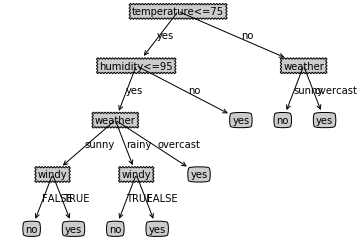

In [17]:
data_set=[['overcast',64,65,'TRUE','yes'],['rainy',65,70,'TRUE','no'],
          ['rainy',68,80,'FALSE','yes'],['sunny',69,70,'FALSE','yes'],
          ['rainy',70,96,'FALSE','yes'],['rainy',71,91,'TRUE','no'],
          ['sunny',72,95,'FALSE','no'],['overcast',72,90,'TRUE','yes'],
          ['rainy',75,80,'FALSE','yes'],['sunny',75,70,'TRUE','yes'],
          ['sunny',80,90,'TRUE','no'],['overcast',81,75,'FALSE','yes'],
          ['overcast',83,86,'FALSE','yes'],['sunny',85,85,'FALSE','no']]
labels=['weather','temperature','humidity','windy']
mytree=create_tree(data_set,labels)
print(mytree)
create_plot(mytree)

In [31]:
# 决策树分类函数  
def classify(inputTree,featLabels,testVec):  
    # 得到树中的第一个特征  
    firstStr = list(inputTree.keys())[0]
    # 得到第一个对应的值  
    secondDict = inputTree[firstStr]  
    if firstStr.find('<')==-1:
        firstLabel=firstStr
    else:
        firstLabel=firstStr[:firstStr.find('<')]
    # 得到树中第一个特征对应的索引  
    featIndex = featLabels.index(firstLabel) 
    classLabel=None
    # 遍历树  
    for key in secondDict.keys():
        if featLabels[featIndex]=='weather'or featLabels[featIndex]=='windy':
            
            # 如果在secondDict[key]中找到了testVec[featIndex]  
            if testVec[featIndex] == key:  
                # 判断secondDict[key]是否为字典  
                if type(secondDict[key]).__name__ == 'dict':  
                    # 若为字典，递归的寻找testVec  
                    classLabel = classify(secondDict[key], featLabels, testVec)  
                else:  
                    # 若secondDict[key]为标签值，则将secondDict[key]赋给classLabel  
                    classLabel = secondDict[key]  
        else: #连续属性：温度和湿度
             splitValue = eval(firstStr[firstStr.find('=')+1:])
             if testVec[featIndex]<=splitValue: #进入左子树
                 if type(secondDict['yes']).__name__=='dict': #该分支不是叶子节点,递归
                     classLabel=classify(secondDict['yes'],featLabels,testVec)
                 else: #如果是叶子,返回结果
                     classLabel=secondDict['yes']
             else:
                 if type(secondDict['no']).__name__=='dict':
                     classLabel=classify(secondDict['no'],featLabels,testVec)
                 else:#如果是叶子节点,返回结果
                     classLabel=secondDict['no']
    # 返回类标签  
    return classLabel    

In [33]:
test_data_set=[['overcast',64,65,'TRUE','yes'],['rainy',65,70,'TRUE','no'],
          ['rainy',68,80,'FALSE','yes'],['sunny',69,70,'FALSE','yes'],
          ['rainy',70,96,'FALSE','yes'],['rainy',71,91,'TRUE','no'],
          ['sunny',72,95,'FALSE','no'],['overcast',72,90,'TRUE','yes'],
          ['rainy',75,80,'FALSE','yes'],['sunny',75,70,'TRUE','yes'],
          ['sunny',80,90,'TRUE','no'],['overcast',81,75,'FALSE','yes'],
          ['overcast',83,86,'FALSE','yes'],['sunny',85,85,'FALSE','no']]
labels=['weather','temperature','humidity','windy']

for testVec in test_data_set:
    #print(testVec)
    print(classify(mytree,labels,testVec))


yes
no
yes
no
yes
no
no
yes
yes
yes
no
yes
yes
no
